# **Image Reconstruction**

In [1]:
# Own modules
from src.utils import show_image, seed_all, MAE, save_model, load_model
from src.data_processing import download_dataset, load_dataset
from src.models import ColorizationNet
from src.train import train
from src.evaluate import validate
from src.predict import predict_image


# Other libraries
import warnings
import os
import torch

# Paths
IMAGES_PATH = "images/"
DATA_PATH = "data/"
MODELS_PATH = "models/"

# seed
seed = 42
seed_all(seed)

d:\Aplicaciones\Python_3_12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CONSTANTS
DATASET_ID = ("testdummyvt/cocohumanparts", "COCO_humanparts")
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
HYPERPARAMETERS = {
    "size": (256, 256),  # Image size
    "batch_size": 16,
    "learning_rate": 0.001,
    "num_epochs": 10,
    "num_layers": 5,
    "base_filters": 32,
    "num_workers": 4,
    "activation": "leakyrelu",
    "dropout": 0.5,
    "optimizer": "adam",
    "loss_function": MAE,
    "scheduler": torch.optim.lr_scheduler.StepLR,
    "scheduler_step_size": 5,
    "scheduler_gamma": 0.1,

}

**Loading the data**

In [4]:
train_dataset, val_dataset = load_dataset(DATA_PATH, HYPERPARAMETERS["size"])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 8
Validation dataset size: 7


In [5]:
train_dataset.image_paths

['data/train_test\\000000000036.jpg',
 'data/train_test\\000000000049.jpg',
 'data/train_test\\000000000061.jpg',
 'data/train_test\\000000000074.jpg',
 'data/train_test\\000000000077.jpg',
 'data/train_test\\000000000086.jpg',
 'data/train_test\\000000000109.jpg',
 'data/train_test\\000000000110.jpg']

In [6]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=HYPERPARAMETERS["batch_size"],
    shuffle=True,
    num_workers=HYPERPARAMETERS["num_workers"],
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=HYPERPARAMETERS["batch_size"],
    shuffle=False,
    num_workers=HYPERPARAMETERS["num_workers"],
)


**Train the model**

In [7]:
model = ColorizationNet(
    num_layers=HYPERPARAMETERS["num_layers"],
    activation=HYPERPARAMETERS["activation"],
    dropout=HYPERPARAMETERS["dropout"],
    base_filters=HYPERPARAMETERS["base_filters"],
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=HYPERPARAMETERS["learning_rate"],
)
scheduler = HYPERPARAMETERS["scheduler"](
    optimizer,
    step_size=HYPERPARAMETERS["scheduler_step_size"],
    gamma=HYPERPARAMETERS["scheduler_gamma"],
)

criterion = HYPERPARAMETERS["loss_function"]


In [8]:
model, train_hist, val_hist = train(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=HYPERPARAMETERS["num_epochs"],
    scheduler=scheduler,
    device=device,
)



Epoch 1/10, Train Loss: 0.2706, Val Loss: 0.2691


d:\Aplicaciones\Python_3_12\Lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/10, Train Loss: 0.2600, Val Loss: 0.2691
Epoch 3/10, Train Loss: 0.2373, Val Loss: 0.2651
Epoch 4/10, Train Loss: 0.2295, Val Loss: 0.2376
Epoch 5/10, Train Loss: 0.2232, Val Loss: 0.3153
Epoch 6/10, Train Loss: 0.2181, Val Loss: 0.3417
Epoch 7/10, Train Loss: 0.2140, Val Loss: 0.3413
Epoch 8/10, Train Loss: 0.2121, Val Loss: 0.3299
Epoch 9/10, Train Loss: 0.2091, Val Loss: 0.3132
Epoch 10/10, Train Loss: 0.2076, Val Loss: 0.2930


In [19]:
# Save the model
save_model(model, MODELS_PATH, "colorization_model.pth")

Model saved to models/colorization_model.pth


In [8]:
# Load the model
model2 = ColorizationNet(
    num_layers=HYPERPARAMETERS["num_layers"],
    activation=HYPERPARAMETERS["activation"],
    dropout=HYPERPARAMETERS["dropout"],
    base_filters=HYPERPARAMETERS["base_filters"],
).to(device)

model = load_model(model2, MODELS_PATH, "colorization_model")



**Prediction**

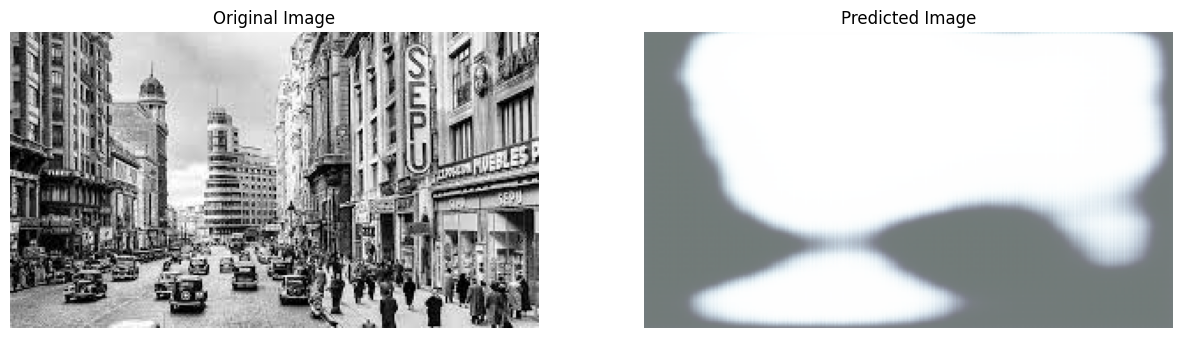

In [9]:
test_image = "data/test/old_madrid.jpeg"

original_image, pred = predict_image(
    model=model2,
    image=test_image,
    device=device,
    size=HYPERPARAMETERS["size"],
)

show_image(original_image, pred)
